# Corner Values Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook")
plt.style.use("ggplot")

In [2]:
dfs = []

for sheet_name in ["corner values config b1", "corner values config c1"]:
    df = pd.read_excel("../data/corner/corner_values.xlsx", header=1, sheet_name=sheet_name)
    df = df[~df.isna().all(axis=1)]
    df = df[~pd.to_numeric(df["T °C"], errors="coerce").isna()]
    df = df.infer_objects()
    df["min-E (NIST)"] = df["min-E (NIST)"].replace("nonIID", 0)
    df["min-E (NIST)"] = pd.to_numeric(df["min-E (NIST)"], errors="coerce")
    df["Board"] = df["Board"].fillna(method="ffill")
    df["config"] = sheet_name[-2:]
    dfs.append(df)

df = pd.concat(dfs)
df.rename({"alim V": "Power Supply [V]", "T °C": "Temp [°C]"}, axis=1, inplace=True)
df.head()

,Board,Temp [°C],Power Supply [V],Mean,aVar,v from Pva,min-E (NIST),# contributors,All distances,config
0,SF2v11_10,24,1.14,140.32,1.10,1.46,0.989742,9,[58 11 36 11 47 11 47 11 47],b1
1,SF2v11_10,24,1.14,140.31,1.13,1.46,0.993166,9,[11 47 11 47 58 11 36 11 47],b1
2,SF2v11_10,24,1.14,140.32,1.14,1.46,0.994269,9,[58 11 36 11 47 11 47 11 47],b1
3,SF2v11_10,24,1.14,140.31,1.14,1.46,0.992876,9,[11 47 58 11 36 11 47 11 47],b1
4,SF2v11_10,24,1.14,140.31,1.12,1.46,0.991439,9,[11 36 11 47 11 47 11 47 58],b1


## Entropy

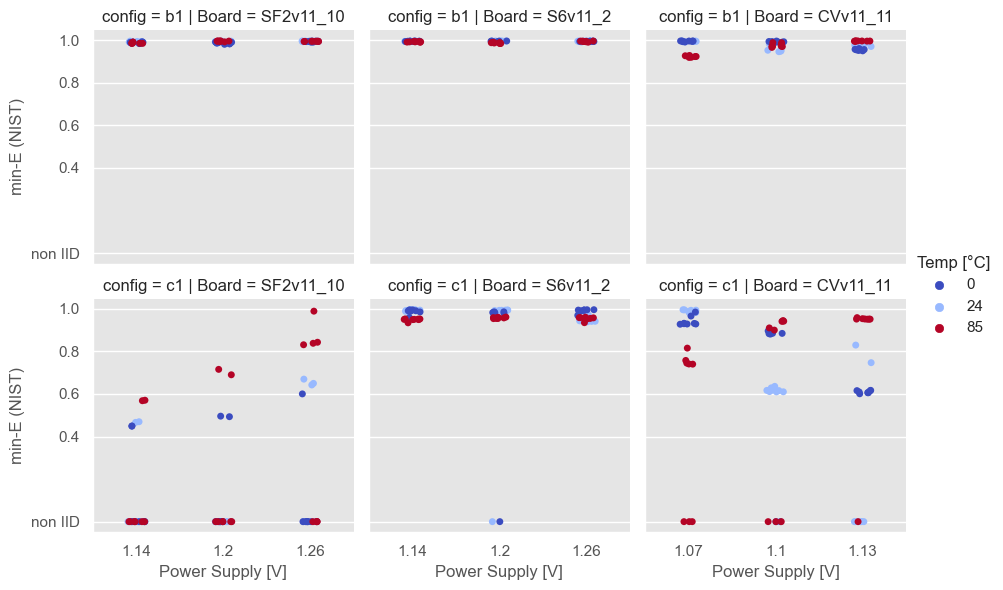

In [3]:
g = sns.FacetGrid(df, col="Board", row="config", sharex="col")
g.map_dataframe(
    sns.stripplot,
    x="Power Supply [V]",
    y="min-E (NIST)",
    hue="Temp [°C]",
    palette="coolwarm",
    native_scale=False,
)
g.add_legend(title="Temp [°C]")
# g.set(xticks=df['alim V'].unique())
g.set(yticks=[0, 0.4, 0.6, 0.8, 1])
g.set_yticklabels(["non IID", "0.4", "0.6", "0.8", "1.0"])
g.savefig("corner_values_Ent.svg")

## Alan Variance

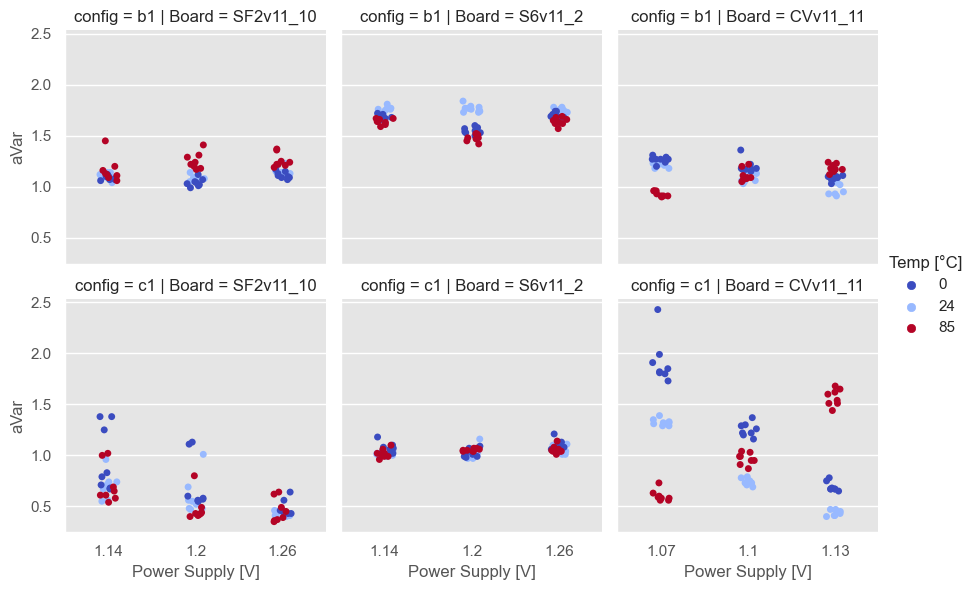

In [4]:
g = sns.FacetGrid(df, col="Board", row="config", sharex="col")
g.map_dataframe(
    sns.stripplot,
    x="Power Supply [V]",
    y="aVar",
    hue="Temp [°C]",
    palette="coolwarm",
    native_scale=False,
)
g.add_legend(title="Temp [°C]")
g.savefig("corner_values_aVar.svg")

## Alan Variance as Entropy Predictor

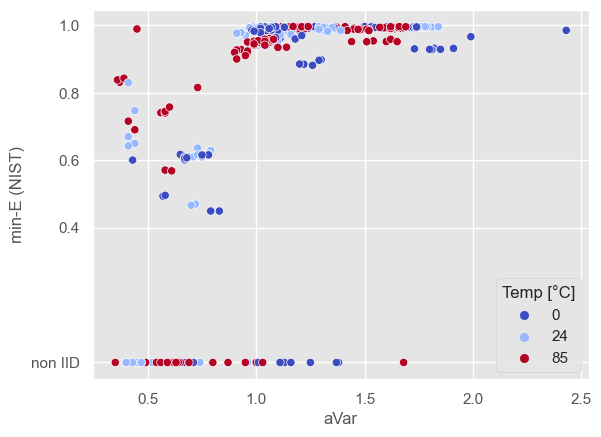

In [5]:
fig, ax = plt.subplots()
sns.scatterplot(data=df, x="aVar", y="min-E (NIST)", hue="Temp [°C]", palette="coolwarm", ax=ax)
ax.set(yticks=[0, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["non IID", "0.4", "0.6", "0.8", "1.0"])
fig.savefig("corner_values_aVar_vs_Ent.svg")

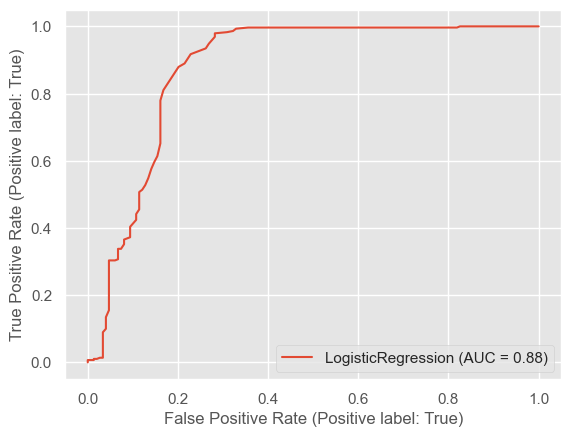

In [6]:
from sklearn import linear_model
from sklearn import metrics

y = df["min-E (NIST)"] > 0.95
X = df[["aVar"]]

model = linear_model.LogisticRegression()
model.fit(X, y)

fig = metrics.RocCurveDisplay.from_estimator(model, X, y)
fig.figure_.savefig("corner_values_aVar_predictive.svg")